In [16]:
import pymongo
from pymongo import MongoClient
import pandas as pd
import numpy as np
import re
import itertools

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.naive_bayes import MultinomialNB

%matplotlib inline
import matplotlib.pyplot as plt

from df_builder_mini_cleaner import *

# Creating the DataFrame

In [2]:
cnn_df = pd.read_csv('data/cnn.csv')
fox_df = pd.read_csv('data/fox.csv')
onion_df = pd.read_csv('data/onion_csv.csv')

In [3]:
df_final = build_df(onion_df, fox_df, cnn_df)

In [5]:
df_final

,Article,Satire,CNN,Fox
0,washington in a statement confirming his suppo...,1,0,0
1,washington irked that the attorney general’s b...,1,0,0
2,stamford ct lamenting that the numbers were mu...,1,0,0
3,nairobi kenya warning that a complete overhaul...,1,0,0
4,napa ca after being lovingly tended by generat...,1,0,0
5,pineville la citing concerns over historically...,1,0,0
6,cambridge ma warning that nothing was more dan...,1,0,0
7,south bend in stumbling through the restaurant...,1,0,0
8,heaven speaking with obvious nostalgia regardi...,1,0,0
9,cary nc competing to secure the new pet’s alle...,1,0,0


# Word Count

In [29]:
def word_count(content_list):
    '''
    Takes in a list of fox articles that is a list of strings
    and then returns an average word count for each article.
    input: list of strings
    output: average word count per article
    '''
    
    count = 0
    words = 0
    
    
    # Come back for more preprocessing
    # Right now this is just a rough estimate
    # because the numbers in the articles are messing up
    # the count
    # (), "" are also messing up the count
    for x in content_list:
        length = len(x.split()) 
        words += length
        count += 1
    print(count)
    print(words)
    print(words/count)
    return words/count

In [30]:
onion_word_count = word_count(list(df_final.Article[0:5000]))

5000
913827
182.7654


In [34]:
cnn_word_count = word_count(list(df_final.Article[5000:10000]))

5000
3691602
738.3204


In [40]:
fox_word_count = word_count(list(df_final.Article[10000:]))

4354
2273203
522.0953146531924


In [45]:
word_counts_df = pd.DataFrame([['Onion', onion_word_count], ['CNN', cnn_word_count], ['Fox', fox_word_count]], columns=['Source', 'Average_Word_Count'])

Text(0.5, 0, 'Source')

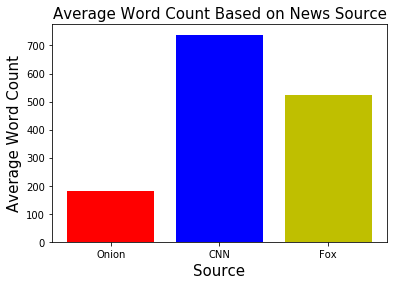

In [48]:
fig, ax = plt.subplots()
plt.bar(word_counts_df.Source.values,word_counts_df.Average_Word_Count, color ='rby')
ax.set_title("Average Word Count Based on News Source", fontsize = 15)
ax.set_ylabel("Average Word Count", fontsize = 15)
ax.set_xlabel("Source", fontsize = 15)

# Models

### Tokenizing and Stemming

In [8]:
porter = PorterStemmer()

In [9]:
def tokenize(doc):
    return [porter.stem(word) for word in word_tokenize(doc)]

### Train Test Split

In [10]:
docs_train, docs_test, y_train, y_test = train_test_split(df_final['Article'], df_final['Satire'])

### TFIDF Vectorization 

In [11]:
vect = TfidfVectorizer(stop_words='english', tokenizer=tokenize)
X_train = vect.fit_transform(docs_train)
X_test = vect.transform(docs_test)

/Users/jphooster22/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_

### Logistic Regression Model

In [12]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

/Users/jphooster22/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [13]:
log_reg_y_pred = log_reg.predict(X_test)
log_reg_con_mat = confusion_matrix(y_test, log_reg_y_pred)
recall_log_reg = log_reg_con_mat[1,1]/(log_reg_con_mat[1,1]+log_reg_con_mat[1,0])
prec_log_reg = log_reg_con_mat[1,1]/(log_reg_con_mat[1,1]+log_reg_con_mat[0,1])
F1_log_reg = ((prec_log_reg*recall_log_reg)/(prec_log_reg+recall_log_reg))*2
F1_log_reg

0.9824980111376294

### Naive Bayes Model

In [14]:
na_ba = MultinomialNB(alpha=.1)
na_ba.fit(X_train, y_train)



MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [15]:
na_ba_pred = na_ba.predict(X_test)
na_ba_con_mat = confusion_matrix(y_test, na_ba_pred)
recall_na_ba= na_ba_con_mat[1,1]/(na_ba_con_mat[1,1]+na_ba_con_mat[1,0])
prec_na_ba = na_ba_con_mat[1,1]/(na_ba_con_mat[1,1]+na_ba_con_mat[0,1])
F1_na_ba = ((prec_na_ba*recall_na_ba)/(prec_na_ba+recall_na_ba))*2
F1_na_ba

0.8938356164383562

# Data Vis for Models

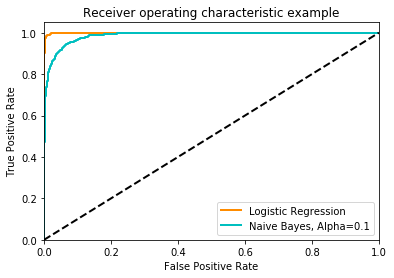

In [17]:
roc_log_reg  = roc_curve(y_test, log_reg.predict_proba(X_test)[:,1], pos_label=1)
roc_na_ba  = roc_curve(y_test, na_ba.predict_proba(X_test)[:,1], pos_label=1)
plt.figure()
lw = 2
plt.plot(roc_log_reg[0], roc_log_reg[1], color='darkorange',
         lw=lw, label='Logistic Regression')

plt.plot(roc_na_ba[0], roc_na_ba[1], color='c',
         lw=lw, label='Naive Bayes, Alpha=0.1')
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[2310   30]
 [  14 1235]]


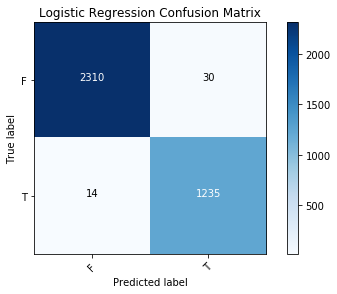

In [20]:
plot_confusion_matrix(log_reg_con_mat,['F','T'], title='Logistic Regression Confusion Matrix')

Confusion matrix, without normalization
[[2297   43]
 [ 205 1044]]


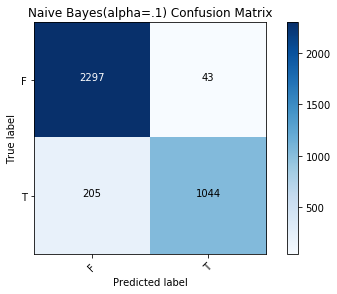

In [21]:
plot_confusion_matrix(na_ba_con_mat,['F','T'], title='Naive Bayes(alpha=.1) Confusion Matrix')

# Feature Exploration

In [73]:
features = vect.get_feature_names()
log_reg_coef = log_reg.coef_.reshape(53108,)

In [69]:
feature_df = pd.DataFrame(features)

In [77]:
feature_coef['Features'] = feature_coef[0]
feature_coef['Beta_Coef'] = log_reg_coef

In [78]:
feature_coef = feature_coef[['Features', 'Beta_Coef']]

In [79]:
feature_coef

,Features,Beta_Coef
0,!,0.635292
1,#,-1.384163
2,$,-1.459037
3,%,-1.828031
4,&,0.628352
5,',0.512057
6,'',0.812804
7,'0062834266,0.008635
8,'alec,0.067073
9,'commerc,0.008635
